In [2]:
import numpy as np
import itertools
import pandas as pd
from scipy.stats import multivariate_normal, norm
import gurobipy as gp
from gurobipy import GRB
from IPython.display import display, Math
from gurobipy import GRB, quicksum
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from itertools import product, combinations
from scipy.spatial.distance import cdist

## Matching Approach Simulation

### Setup 1

##### Modify the balancing weight function to make the optimized weight a binary output of {0,1}

#### Limitations

After changing the decision variable weight $w_i$ as binary number and objective function into maximize the sample size, if I continue follow the weight balancing constraints, it means force the selected subset to exactly replicate the entire sample’s sum of covariates in the plus and minus group, the entire sample’s sum in the minus group, etc. This will be most likely infeasible if $w_i \in{0,1}$. It cannot pick a strict subset that exactly reproduces the entire sample’s sums.

Therefore, I allowed a tolerance on the SMD of the lhs and rhs for every balancing constraints. I calculated the SMD of the lhs and rhs of every balancing constraints and let them smaller than this tolerance value. 

In [3]:
np.random.seed(123)

D = 5  # number of covariates
K = 3 # number of binary covariates
rho = 0.0 # correlation
Sigma = rho * np.ones((D, D)) + (1 - rho) * np.eye(D)
# constructs a covariance matrix where diagonal elements are 1 and off-diagonal elements are rho.
# when rho = 0.0, Sigma is an identity matrix, meaning all covariates are independent.

# coefficient vectors for generating Z 
beta1 = np.array([ 1/4,  2/4,  0.0,  3/4,  1.0])
beta2 = np.array([ 3/4,  1/4,  1.0,  0.0,  2/4])
beta3 = np.array([ 1.0,  0.0,  3/4,  2/4,  1/4])

# Estimate tau_1, tau_2, tau_3 under each outcome model.

# implements the logistic function for probability calculations
def logistic(x): 
    return 1.0 / (1.0 + np.exp(-x))

# assigns +1 or -1 to Z1, Z2, Z3 based on these probabilities p1, p2, p3
def generate_treatments(X):
    # initializes a Z matrix (N x K) where each row represents an individual's treatment status.
    Z = np.zeros((X.shape[0], K)) 
    # computes treatment probabilities using logistic regression.
    p1 = logistic(X @ beta1)
    # assigns +1 or -1 to Z1, Z2, Z3 based on these probabilities p1, p2, p3
    Z1 = (np.random.rand(X.shape[0]) < p1).astype(int)*2 - 1
    Z[:, 0] = Z1

    p2 = logistic(X @ beta2)
    Z2 = (np.random.rand(X.shape[0]) < p2).astype(int)*2 - 1
    Z[:, 1] = Z2

    p3 = logistic(X @ beta3)
    Z3 = (np.random.rand(X.shape[0]) < p3).astype(int)*2 - 1
    Z[:, 2] = Z3

    return Z

def make_contrast_vectors(K):
    # generates all 2^K possible combinations of treatments, each treatment can be -1 or +1
    combos = np.array(list(product([-1,1], repeat=K)))  # shape (8,3)
    # main-effect vectors
    # creates contrast vectors for each treatment
    g = {}
    for k in range(K):
        # assigns +1 if the treatment is +1, otherwise assigns -1
        gk = np.where(combos[:, k] == +1, +1, -1) 
        g[k+1] = gk

    return g, combos

g_dict, Z_all = make_contrast_vectors(K)  # Z_all is shape (8,3), the matrix of all possible treatment assignments

# generate true main effects
def true_main_effects(Yfn, combos=Z_all):
    # generates a large population (bigN = 200000) for estimating expected treatment effects
    bigN = 200000  
    # generates samples from a multivariate normal distribution with mean vector [0, 0, 0, 0, 0]
    Xbig = np.random.multivariate_normal(np.zeros(D), Sigma, size=bigN) 
    # match the simulation in section 5.1 where mu = (0.1, 0.1, 0.1, 0, 0).T
    Xbig[:,0] += 0.1
    Xbig[:,1] += 0.1
    Xbig[:,2] += 0.1
    
    # store expected outcomes for each treatment combination
    EYZ = np.zeros(len(combos)) 
    for i,z in enumerate(combos):
        # expands z across bigN rows
        Zbig = np.tile(z, (bigN, 1))  # shape (bigN,3)
        # computes expected outcomes for treatment z using function Yfn(Xbig, Zbig).
        Evals = Yfn(Xbig, Zbig)       # now shape (bigN,)
        # stores the mean outcome for each treatment condition
        EYZ[i] = np.mean(Evals)

    tau = {}
    factor = 1 / (2 ** (K - 1))  # Compute the factor for scaling
    for k in range(1, K+1):
        # retrieves contrast vector for the k-th treatment.
        gk = g_dict[k]
        # computes the main effect estimate
        #tau_k = np.mean(gk * EYZ)  
        tau_k = factor * np.dot(gk, EYZ)  
        tau[k] = tau_k
    return tau


def Y_model_additive(X, Z):
    sumX = 2 * np.sum(X, axis=1)  # factor 2
    sumZ = np.sum(Z, axis=1)
    return sumX + sumZ

def Y_model_het(X, Z):
    sumX = np.sum(X, axis=1)*2.0
    sumZ = np.sum(Z, axis=1)
    return sumX + (np.sum(X, axis=1)*sumZ)

def Y_model_mis(X, Z):
    X1 = X[:,0]
    X2 = X[:,1]
    part1 = np.sin(X1) + np.cos(X2)
    part2 = (np.minimum(1.0, X1) + X2) * Z[:,0]
    # sum_i(X_i) * sum_{j=2..3}(Z_j)
    part3 = np.sum(X, axis=1) * np.sum(Z[:,1:], axis=1)
    return part1 + part2 + part3

def simulate_Y(X, Z, model="additive"):
    if model=="additive":
        meanY = Y_model_additive(X, Z)
    elif model=="heterogeneous":
        meanY = Y_model_het(X, Z)
    elif model=="misspecified":
        meanY = Y_model_mis(X, Z)
    else:
        raise ValueError("Unknown model")
    return meanY + np.random.randn(len(X))  # add normal(0,1)

def solve_matching_additive(X, Z, tol=0.1):

    N, D = X.shape
    K = Z.shape[1]

    # Define group membership indicators
    Aplus = np.where(Z > 0, 1.0, 0.0)
    Aminus = 1.0 - Aplus

    # Full sample sums (for converting sums into means)
    sumX = np.sum(X, axis=0)
    # Standard deviation for each covariate (population std)
    std_X = np.std(X, axis=0, ddof=0)

    # Build the model
    model = gp.Model("AdditiveBalance_binary")
    model.setParam('OutputFlag', 0)

    # Decision variables: w_i in {0,1}
    w_vars = model.addVars(N, vtype=GRB.BINARY, name="w")
    # Objective: maximize the number of selected units
    model.setObjective(gp.quicksum(w_vars[i] for i in range(N)), GRB.MAXIMIZE)

    # Relaxed balancing constraints for each factor and covariate dimension:
    for k_ in range(K):
        for d_ in range(D):
            lhs_plus  = gp.quicksum(w_vars[i] * Aplus[i, k_] * X[i, d_] for i in range(N))
            lhs_minus = gp.quicksum(w_vars[i] * Aminus[i, k_] * X[i, d_] for i in range(N))
            # Instead of exact equality of sums, we require the difference in means to be within tol std deviations:
            model.addConstr((lhs_plus/N - sumX[d_]/N) / std_X[d_] <= tol)
            model.addConstr((lhs_plus/N - sumX[d_]/N) / std_X[d_] >= -tol)
            model.addConstr((lhs_minus/N - sumX[d_]/N) / std_X[d_] <= tol)
            model.addConstr((lhs_minus/N - sumX[d_]/N) / std_X[d_] >= -tol)

    # Relaxed interaction constraints:
    # For interactions up to order K_prime (here set as min(K,2) as in your original code)
    K_prime = min(K, 3)
    Z_all = np.array(list(product([-1, 1], repeat=K)))
    factor = 1 / (2**(K - 1))
    for k_size in range(2, K_prime + 1):
        for J in combinations(range(K), k_size):
            # Compute the interaction for each individual:
            Z_interaction = np.prod(Z[:, list(J)], axis=1)
            lhs = gp.quicksum(w_vars[i] * Z_interaction[i] for i in range(N))
            # Compute the target value:
            g_interaction = np.prod(Z_all[:, list(J)], axis=1)
            rhs = factor * np.sum(g_interaction)
            # Compute standard deviation of the interaction variable (over full sample)
            std_interaction = np.std(Z_interaction, ddof=0)
            # Relax the equality constraint using tol (scaled back to the sum scale)
            model.addConstr((lhs/N - rhs/N)/ std_interaction <= tol)
            model.addConstr((lhs/N - rhs/N)/ std_interaction <= tol)
            
    # Solve the model
    model.optimize()
    if model.status != GRB.OPTIMAL:
        #print("Binary additive-balance model infeasible or no optimal solution found.")
        return None

    w_opt = np.array([w_vars[i].X for i in range(N)])
    return w_opt

def solve_matching_heterogeneous(X, Z, tol=1.0, lambda_penalty=100.0):

    N, D = X.shape
    K = Z.shape[1]

    model = gp.Model("HeteroBinary")
    model.setParam('OutputFlag', 0)

    # Decision variables: w_i in {0,1}
    w_vars = model.addVars(N, vtype=GRB.BINARY, name="w")

    basis_vals = [np.ones(N)]
    for d_ in range(D):
        basis_vals.append(X[:, d_])
    # Treatment groupings: intercept and main effects (can be extended)
    J_list = [()] + [(j,) for j in range(K)]
    n_s = len(basis_vals)
    n_J = len(J_list)

    # Precompute Qvals for each unit, basis function, and treatment grouping.
    Qvals = np.zeros((N, n_s, n_J))
    for j_idx, J_ in enumerate(J_list):
        if len(J_) == 0:
            Zp = np.ones(N)
        else:
            Zp = np.prod(Z[:, list(J_)], axis=1)
        for s_ in range(n_s):
            Qvals[:, s_, j_idx] = basis_vals[s_] * Zp

    # Compute target values over all treatment combinations.
    Aplus = np.where(Z > 0, 1.0, 0.0)
    Aminus = 1.0 - Aplus
    Z_all = np.array(list(product([-1, 1], repeat=K)))
    bigQ = np.zeros((len(Z_all), n_s, n_J))
    for z_index, z_ in enumerate(Z_all):
        for j_idx, J_ in enumerate(J_list):
            z_prod = np.prod(z_[list(J_)])
            for s_ in range(n_s):
                bigQ[z_index, s_, j_idx] = z_prod * np.sum(basis_vals[s_])
    factor = 1.0 / (2.0**(K - 1))
    target_plus = np.zeros((K, n_s, n_J))
    target_minus = np.zeros((K, n_s, n_J))
    for k_ in range(K):
        for z_index, z_ in enumerate(Z_all):
            if z_[k_] == +1:
                coeff_plus = 1.0
                coeff_minus = 0.0
            else:
                coeff_plus = 0.0
                coeff_minus = 1.0
            for s_ in range(n_s):
                for j_idx in range(n_J):
                    target_plus[k_, s_, j_idx] += factor * coeff_plus * bigQ[z_index, s_, j_idx]
                    target_minus[k_, s_, j_idx] += factor * coeff_minus * bigQ[z_index, s_, j_idx]

    # List to collect slack variables.
    slack_vars = []
    for k_ in range(K):
        for s_ in range(n_s):
            for j_idx in range(n_J):
                lhs_plus = gp.quicksum(Aplus[i, k_] * Qvals[i, s_, j_idx] * w_vars[i] for i in range(N))
                lhs_minus = gp.quicksum(Aminus[i, k_] * Qvals[i, s_, j_idx] * w_vars[i] for i in range(N))
                # Compute standard deviations over full sample:
                values_plus = Aplus[:, k_] * Qvals[:, s_, j_idx]
                std_plus = np.std(values_plus, ddof=0)
                values_minus = Aminus[:, k_] * Qvals[:, s_, j_idx]
                std_minus = np.std(values_minus, ddof=0)

                # Slack variables for plus side
                s_plus = model.addVar(lb=0, name=f"s_plus_{k_}_{s_}_{j_idx}")
                s_minus = model.addVar(lb=0, name=f"s_minus_{k_}_{s_}_{j_idx}")
                slack_vars.extend([s_plus, s_minus])
                model.addConstr((lhs_plus / N - target_plus[k_, s_, j_idx] / N) / std_plus <= tol + s_plus)
                model.addConstr((lhs_plus / N - target_plus[k_, s_, j_idx] / N) / std_plus >= -tol - s_minus)

                # Slack variables for minus side
                s_plus_m = model.addVar(lb=0, name=f"s_plus_m_{k_}_{s_}_{j_idx}")
                s_minus_m = model.addVar(lb=0, name=f"s_minus_m_{k_}_{s_}_{j_idx}")
                slack_vars.extend([s_plus_m, s_minus_m])
                model.addConstr((lhs_minus / N - target_minus[k_, s_, j_idx] / N) / std_minus <= tol + s_plus_m)
                model.addConstr((lhs_minus / N - target_minus[k_, s_, j_idx] / N) / std_minus >= -tol - s_minus_m)

    obj = gp.quicksum(w_vars[i] for i in range(N)) - lambda_penalty * gp.quicksum(slack_vars)
    model.setObjective(obj, GRB.MAXIMIZE)

    model.optimize()
    if model.status != GRB.OPTIMAL:
        return None

    w_opt = np.array([w_vars[i].X for i in range(N)])
    return w_opt

    
#  Do an naive difference in means for each factor to estimate the factorial effect
def estimate_main_effects_matched(Y, Z, match_vec):
    # Weighted means become simple means if match_vec is 0/1
    # tau_k = mean(Y | Z_k=+1 & matched) - mean(Y | Z_k=-1 & matched)
    tau_est_matched = {}
    for k_ in range(K):
        plus_mask  = (Z[:, k_] == +1) & (match_vec == 1)
        minus_mask = (Z[:, k_] == -1) & (match_vec == 1)
        if np.sum(plus_mask) < 1 or np.sum(minus_mask) < 1:
            tau_est_matched[k_+1] = np.nan
        else:
            mean_plus  = np.mean(Y[plus_mask])
            mean_minus = np.mean(Y[minus_mask])
            tau_est_matched[k_+1] = mean_plus - mean_minus
    return tau_est_matched


# Getting the standardized mean difference (SMD) for each factor k and each covariate dimension d
def get_covariate_balance_matched(X, Z, selection):
    sd_X = np.std(X, axis=0, ddof=1)
    smd = np.zeros((K, D))
    for k in range(K):
        plus_mask = (Z[:, k] == +1) & (selection == 1)
        minus_mask = (Z[:, k] == -1) & (selection == 1)
        if np.sum(plus_mask) > 0:
            mean_plus = np.mean(X[plus_mask], axis=0)
        else:
            mean_plus = np.full(X.shape[1], np.nan)
        if np.sum(minus_mask) > 0:
            mean_minus = np.mean(X[minus_mask], axis=0)
        else:
            mean_minus = np.full(X.shape[1], np.nan)
        diff = mean_plus - mean_minus
        smd[k, :] = diff / (sd_X + 1e-15)
    return smd


# print an array with 5 significant figures per float.
def print_array_5sig(arr):
    with np.printoptions(formatter={'float_kind': lambda x: f"{x:.5g}"}):
        print(arr)

def run_all_simulations(n_sims=100, N=500, tol_add=0.1, tol_het=0.1, lambda_penalty=1000000.0):
    # Outcome models for RMSE simulation.
    outcome_models = ["additive", "heterogeneous", "misspecified"]
    # Containers for squared error for each outcome model and matching method.
    rmse_sq_results = {model: {"add": [], "het": []} for model in outcome_models}
    
    # Containers for SMD.
    orig_smd_list = []
    smd_add_list = []
    smd_het_list = []
    
    # Containers for ESS.
    ess_add_list = []
    ess_het_list = []
    
    # Loop over simulations.
    for sim in range(n_sims):
        # Generate covariates and treatments.
        mu = np.array([0.1, 0.1, 0.1, 0.0, 0.0])
        Xraw = np.random.multivariate_normal(mean=mu, cov=Sigma, size=N)
        Z_ = generate_treatments(Xraw)
        
        # Compute original covariate balance (SMD) using all units.
        orig_smd = get_covariate_balance_matched(Xraw, Z_, np.ones(N))
        orig_smd_list.append(orig_smd)
        
        # Compute matching solutions.
        matchA = solve_matching_additive(Xraw, Z_, tol=tol_add)
        matchH = solve_matching_heterogeneous(Xraw, Z_, tol=tol_het, lambda_penalty=lambda_penalty)
        
        # SMD after additive matching.
        if matchA is not None:
            smd_add = get_covariate_balance_matched(Xraw, Z_, matchA)
        else:
            smd_add = np.full((K, D), np.nan)
        smd_add_list.append(smd_add)
        
        # SMD after heterogeneous matching.
        if matchH is not None:
            smd_het = get_covariate_balance_matched(Xraw, Z_, matchH)
        else:
            smd_het = np.full((K, D), np.nan)
        smd_het_list.append(smd_het)
        
        # Compute effective sample sizes.
        ess_add = np.sum(matchA) if matchA is not None else np.nan
        ess_het = np.sum(matchH) if matchH is not None else np.nan
        ess_add_list.append(ess_add)
        ess_het_list.append(ess_het)
        
        # For each outcome model, simulate Y and compute squared errors for the three main effects.
        for mtype in outcome_models:
            Y_ = simulate_Y(Xraw, Z_, model=mtype)
            
            # Get the true outcome function.
            if mtype == "additive":
                Yfn = Y_model_additive
            elif mtype == "heterogeneous":
                Yfn = Y_model_het
            elif mtype == "misspecified":
                Yfn = Y_model_mis
            true_tau = true_main_effects(Yfn)
            
            # Define the indices for the three main effects (assuming indices 1, 2, and 3).
            true_effects = np.array([true_tau[1], true_tau[2], true_tau[3]])
            
            # Additive matching error.
            if matchA is not None:
                tA = estimate_main_effects_matched(Y_, Z_, matchA)
                effects_est_A = np.array([tA[1], tA[2], tA[3]])
                sq_error_A = (effects_est_A - true_effects) ** 2
            else:
                sq_error_A = np.array([np.nan, np.nan, np.nan])
            rmse_sq_results[mtype]["add"].append(sq_error_A)
            
            # Heterogeneous matching error.
            if matchH is not None:
                tH = estimate_main_effects_matched(Y_, Z_, matchH)
                effects_est_H = np.array([tH[1], tH[2], tH[3]])
                sq_error_H = (effects_est_H - true_effects) ** 2
            else:
                sq_error_H = np.array([np.nan, np.nan, np.nan])
            rmse_sq_results[mtype]["het"].append(sq_error_H)
    
    # Aggregate RMSE by taking the square root of the mean squared error for each effect.
    aggregated_rmse = {}
    for mtype in outcome_models:
        rmse_add = np.sqrt(np.nanmean(np.array(rmse_sq_results[mtype]["add"]), axis=0))
        rmse_het = np.sqrt(np.nanmean(np.array(rmse_sq_results[mtype]["het"]), axis=0))
        aggregated_rmse[mtype] = {
            "true_tau": true_tau,  # Assuming true_tau remains constant across simulations.
            "rmse_add": rmse_add,
            "rmse_het": rmse_het
        }
    
    # Aggregate SMD.
    aggregated_smd = {
        "mean_orig_smd": np.nanmean(np.array(orig_smd_list), axis=0),
        "mean_smd_add": np.nanmean(np.array(smd_add_list), axis=0),
        "mean_smd_het": np.nanmean(np.array(smd_het_list), axis=0)
    }
    
    # Aggregate ESS.
    aggregated_ess = {
        "mean_ess_add": np.nanmean(np.array(ess_add_list)),
        "mean_ess_het": np.nanmean(np.array(ess_het_list))
    }
    
    # Return the combined simulation results.
    simulation_results = {
        "rmse": aggregated_rmse,
        "smd": aggregated_smd,
        "ess": aggregated_ess
    }
    return simulation_results



In [89]:
np.random.seed(123)

if __name__ == "__main__":
    simulation_dict = run_all_simulations(n_sims=100, N=200, tol_add=0.02, tol_het=0.01, lambda_penalty=100000.0)
    
    # Print RMSE results (by outcome model).
    print("RMSE Results (by outcome model):")
    for mtype in simulation_dict["rmse"]:
        print(f"Model {mtype}:")
        print("True main effects:", simulation_dict["rmse"][mtype]['true_tau'])
        print("RMSE (additive matching):", simulation_dict["rmse"][mtype]["rmse_add"])
        print("RMSE (heterogeneous matching):", simulation_dict["rmse"][mtype]["rmse_het"])
    
    # Print SMD results.
    print("\nSMD Results:")
    print("Original covariate SMD:")
    print_array_5sig(simulation_dict["smd"]["mean_orig_smd"])
    print("\nSMD after additive matching:")
    print_array_5sig(simulation_dict["smd"]["mean_smd_add"])
    print("\nSMD after heterogeneous matching:")
    print_array_5sig(simulation_dict["smd"]["mean_smd_het"])
    
    # Print ESS results.
    print("\nEffective Sample Size Results:")
    print("ESS (additive matching):", simulation_dict["ess"]["mean_ess_add"])
    print("ESS (heterogeneous matching):", simulation_dict["ess"]["mean_ess_het"])


RMSE Results (by outcome model):
Model additive:
True main effects: {1: np.float64(0.200152962400957), 2: np.float64(0.6173216233669505), 3: np.float64(0.6173216233669505)}
RMSE (additive matching): [nan nan nan]
RMSE (heterogeneous matching): [1.46202892 1.58164127 0.07489925]
Model heterogeneous:
True main effects: {1: np.float64(0.200152962400957), 2: np.float64(0.6173216233669505), 3: np.float64(0.6173216233669505)}
RMSE (additive matching): [nan nan nan]
RMSE (heterogeneous matching): [0.66611399 0.93529688 0.28102313]
Model misspecified:
True main effects: {1: np.float64(0.200152962400957), 2: np.float64(0.6173216233669505), 3: np.float64(0.6173216233669505)}
RMSE (additive matching): [nan nan nan]
RMSE (heterogeneous matching): [0.11807106 0.00805098 0.28940114]

SMD Results:
Original covariate SMD:
[[0.38902 0.16226 0.21013 0.85365 0.60809]
 [0.6292 0.52313 0.52265 0.030052 0.42912]
 [0.71315 -0.30834 0.48539 0.46413 0.1415]]

SMD after additive matching:
[[nan nan nan nan nan]

/var/folders/3_/4rpg118x5kl_s2bsjcfwflfc0000gn/T/ipykernel_10858/65711185.py:403: RuntimeWarning: Mean of empty slice
  rmse_add = np.sqrt(np.nanmean(np.array(rmse_sq_results[mtype]["add"]), axis=0))
/var/folders/3_/4rpg118x5kl_s2bsjcfwflfc0000gn/T/ipykernel_10858/65711185.py:414: RuntimeWarning: Mean of empty slice
  "mean_smd_add": np.nanmean(np.array(smd_add_list), axis=0),
/var/folders/3_/4rpg118x5kl_s2bsjcfwflfc0000gn/T/ipykernel_10858/65711185.py:420: RuntimeWarning: Mean of empty slice
  "mean_ess_add": np.nanmean(np.array(ess_add_list)),


### The plots

#### The plot of the root mean squared error (RMSE) for estimating three main effects using two estimators matched additive and matched heterogeneous:

#### The plot of the standardized mean differences(SMDs) for estimating three main effects using two estimators matched additive and matched heterogeneous

#### The plot of the selected effective sample size(ESS) for estimating three main effects using two estimators matched additive and matched heterogeneous

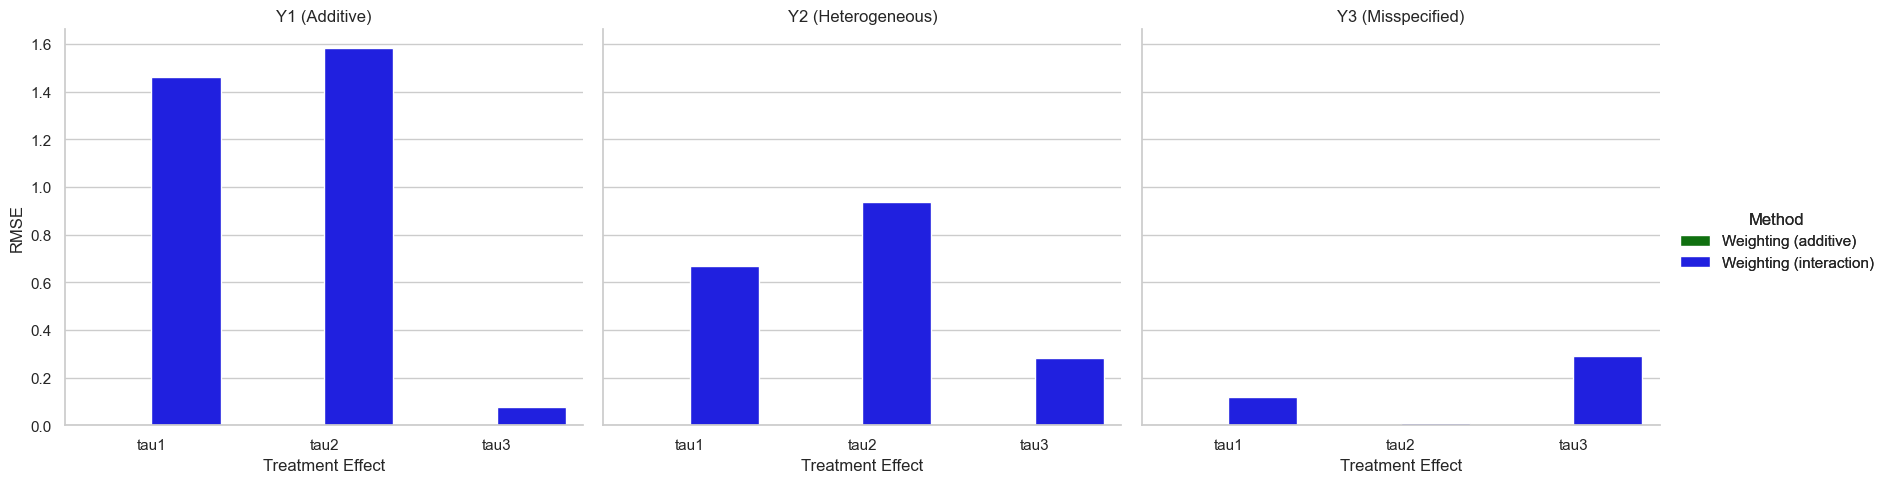

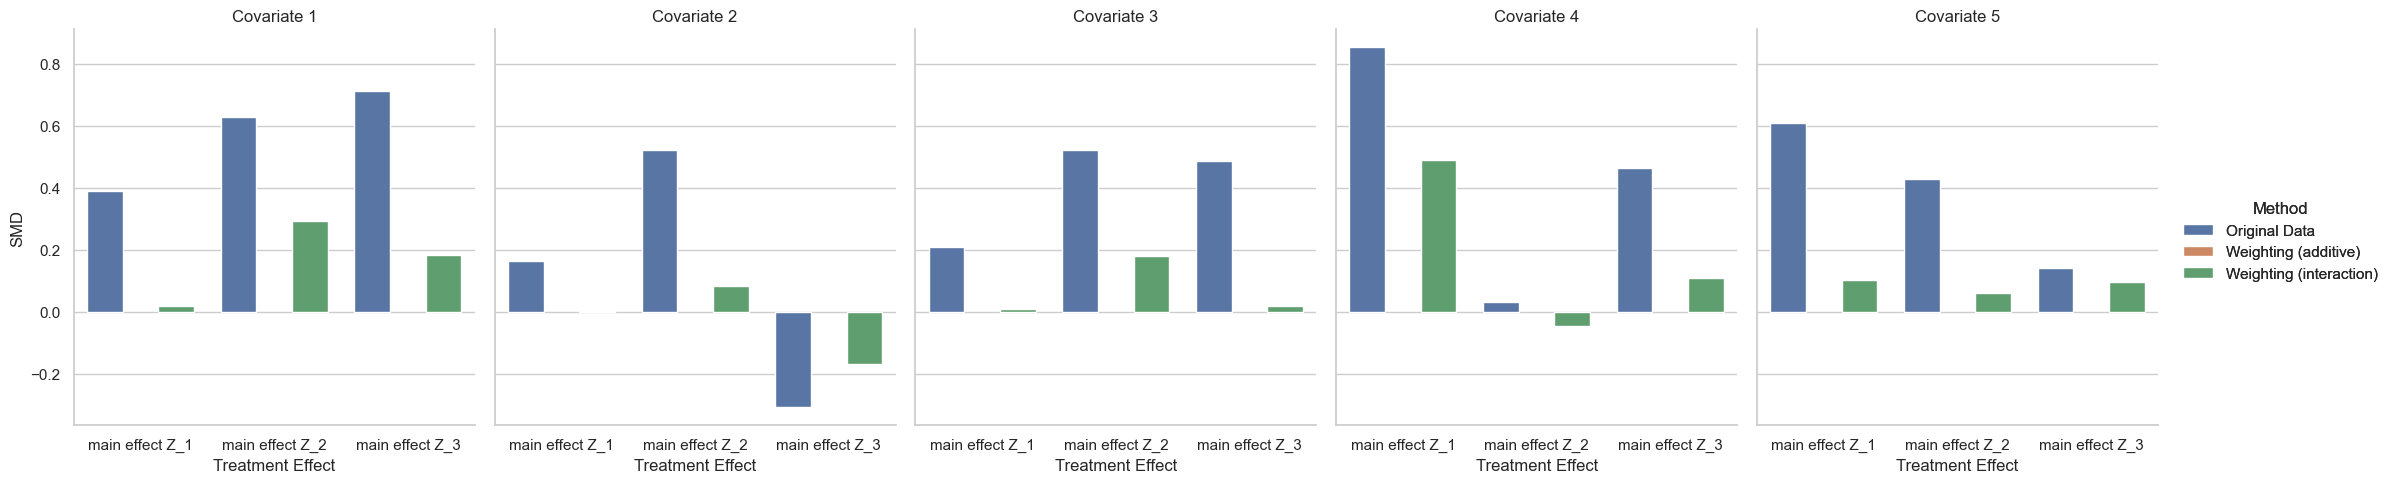

/var/folders/3_/4rpg118x5kl_s2bsjcfwflfc0000gn/T/ipykernel_10858/2220430623.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g_ess = sns.catplot(


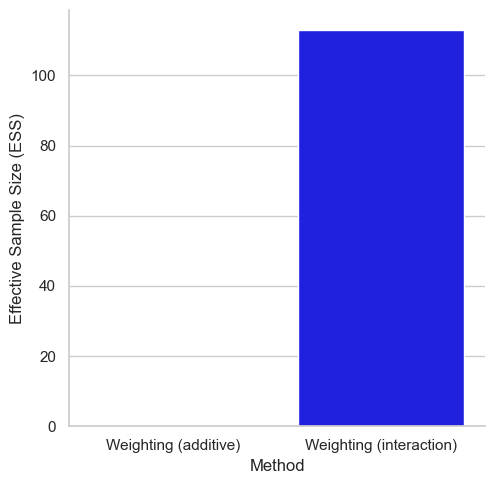

In [101]:
def plot_simulation_results(simulation_dict):
    rmse_results = simulation_dict["rmse"]
    effects = ['tau1', 'tau2', 'tau3']
    methods = ["rmse_add", "rmse_het"]
    method_names = ["Weighting (additive)", "Weighting (interaction)"]
    models = {"additive": "Y1 (Additive)", 
              "heterogeneous": "Y2 (Heterogeneous)", 
              "misspecified": "Y3 (Misspecified)"}
    
    data_rmse = []
    # Loop over outcome models (each contains keys "rmse_add" and "rmse_het").
    for model_type, res in rmse_results.items():
        for method, mname in zip(methods, method_names):
            # Each RMSE array is assumed to be of shape (3,) corresponding to tau1, tau2, tau3.
            rmse_values = res[method]
            for i, eff in enumerate(effects):
                data_rmse.append([models[model_type], eff, rmse_values[i], mname])
    
    df_rmse = pd.DataFrame(data_rmse, columns=["Outcome Model", "Effect", "RMSE", "Method"])
    
    sns.set(style="whitegrid")
    g_rmse = sns.catplot(
        data=df_rmse,
        x="Effect",
        y="RMSE",
        hue="Method",
        col="Outcome Model",
        kind="bar",
        palette=['green', 'blue'],
        height=5,
        aspect=1
    )
    g_rmse.set_axis_labels("Treatment Effect", "RMSE")
    g_rmse.set_titles("{col_name}")
    g_rmse.set_xticklabels(rotation=0)
    g_rmse.add_legend(title="Method")
    plt.show()
    
    smd_results = simulation_dict["smd"]
    effects_smd = ['main effect Z_1', 'main effect Z_2', 'main effect Z_3']
    methods_smd = ["Original Data", "Weighting (additive)", "Weighting (interaction)"]
    keys_smd = ["mean_orig_smd", "mean_smd_add", "mean_smd_het"]
    
    data_smd = []
    for key, method_name in zip(keys_smd, methods_smd):
        smd_values = smd_results[key]  # assumed shape (3, D)
        n_effects, n_cov = smd_values.shape
        for i in range(n_effects):
            for j in range(n_cov):
                data_smd.append([effects_smd[i], f"Covariate {j+1}", smd_values[i, j], method_name])
    
    df_smd = pd.DataFrame(data_smd, columns=["Effect", "Covariate", "SMD", "Method"])
    
    sns.set(style="whitegrid")
    g_smd = sns.catplot(
        data=df_smd,
        x="Effect",
        y="SMD",
        hue="Method",
        col="Covariate",
        kind="bar",
        height=5,
        aspect=0.8
    )
    g_smd.set_axis_labels("Treatment Effect", "SMD")
    g_smd.set_titles("{col_name}")
    g_smd.add_legend(title="Method")
    plt.show()
    
    ess_results = simulation_dict["ess"]
    methods_ess = ["Weighting (additive)", "Weighting (interaction)"]
    keys_ess = ["mean_ess_add", "mean_ess_het"]
    
    data_ess = []
    for key, method_name in zip(keys_ess, methods_ess):
        data_ess.append(["ESS", method_name, ess_results[key]])
    
    df_ess = pd.DataFrame(data_ess, columns=["Metric", "Method", "ESS"])
    
    sns.set(style="whitegrid")
    g_ess = sns.catplot(
        data=df_ess,
        x="Method",
        y="ESS",
        kind="bar",
        palette=['green', 'blue'],
        height=5,
        aspect=1
    )
    g_ess.set_axis_labels("Method", "Effective Sample Size (ESS)")
    g_ess.add_legend()
    plt.show()

plot_simulation_results(simulation_dict)

## Setup 2

### Method 1


I clustered the selected units (weight = 1) into matched sets. In this approach, I designate a unit as the representative of a matched set and assign every other unit to one of these clusters. The cost for assigning unit j to cluster i is the Mahalanobis distance between their covariate vectors. In addition, I added a term in the objective to encourage forming more matched sets so that I'm are not forced into one giant matched set.

Taken the ideas from the Zubizarreta’s paper, I extended the matching MIP to include additional constraints that target specific imbalance measures, which is the differences in covariate means. I penalizes imbalance in covariate totals across clusters directly in the objective function. ​It penalize imbalances in the covariate distributions within each cluster so that the units in each cluster have similar covariate distributions. For instance, for each potential matched set (cluster): Compute the cluster’s (weighted) average of each covariate. Then compare it to the overall mean for that covariate in the selected subset. Introduce auxiliary variables to capture the absolute difference (imbalance) between the cluster mean and the overall mean. Add to objective a weighted sum of these imbalance measures with weights chosen based on how much imbalance we want to penalize.

Thus, the objective function becomes something like:

$$
\text{minimize} \quad \sum_{(i,j)} d_{(i,j)} \cdot x_{(i,j)} - \gamma \sum_i y_i + \sum_{(i,k)} \omega_k \cdot z_{(i,k)}
$$

where:

- $ x_{(i,j)} = 1$ if unit $j$ is assigned to facility $i$;
- $y_i = 1$ if unit $i$ is chosen as a cluster center;
- $ d_{(i,j)} $ is the Mahalanobis distance between units $i$ and $j$;
- For each cluster $i$ and each covariate $k$, $ z_{(i,k)} $ is an auxiliary variable that measures the absolute deviation of the cluster mean for covariate $k$ from the overall mean for covariate $k$;
- $\omega_k $ are the weights penalizing imbalance in each covariate, which is all set to 5.0 now;
- $\gamma$ hyperparameter is used to encourage forming more matched sets (higher = less matched sets, lower = more matched sets)
	- The idea being, that more matched sets = higher precision/closer distance within that matched set, so we have better guarantees on the actual covariate balance within each matched set, as opposed to one single matched set where covariate balance can vary
	- However, tradeoff is that we will have smaller samples within each matched set, and we may also not have observations within a matched set that are representative of the whole treatment combination space (i.e, you will have multiple observations with 1-1-0 treatment and only one of 0-0-1, which isn't reliable for making a causal estimate).

In [4]:
def solve_matching_facility(X, gamma=0.3, w_balance=None):
    n, p = X.shape
    if w_balance is None:
        w_balance = np.full(p, 5.0)  # Lower penalty weight
    
    # Compute Mahalanobis distance matrix
    covX = np.cov(X.T)
    inv_covX = np.linalg.inv(covX)
    d_matrix = cdist(X, X, metric='mahalanobis', VI=inv_covX)
    
    BigM = 1e6  # Increased BigM constant
    model = gp.Model("FacilityLocationMatching_Balance")
    model.setParam('OutputFlag', 0)  # set to 1 for more solver output (for debugging)
    model.setParam('TimeLimit', 60)    # allow 60 seconds
    
    # Decision variables
    y = {i: model.addVar(vtype=GRB.BINARY, name=f"y_{i}") for i in range(n)}
    x = {(i,j): model.addVar(vtype=GRB.BINARY, name=f"x_{i}_{j}") for i in range(n) for j in range(n)}
    
    # Auxiliary variables:
    S = {i: model.addVar(vtype=GRB.CONTINUOUS, lb=0, name=f"S_{i}") for i in range(n)}
    T = {(i, k): model.addVar(vtype=GRB.CONTINUOUS, name=f"T_{i}_{k}") for i in range(n) for k in range(p)}
    z = {(i, k): model.addVar(vtype=GRB.CONTINUOUS, lb=0, name=f"z_{i}_{k}") for i in range(n) for k in range(p)}
    model.update()
    
    # Each unit j must be assigned to exactly one facility.
    for j in range(n):
        model.addConstr(gp.quicksum(x[(i,j)] for i in range(n)) == 1, name=f"assign_{j}")
    # A unit j can be assigned only if facility i is open.
    for i in range(n):
        for j in range(n):
            model.addConstr(x[(i,j)] <= y[i], name=f"link_{i}_{j}")
    # Define S[i] and T[i,k]
    for i in range(n):
        model.addConstr(S[i] == gp.quicksum(x[(i,j)] for j in range(n)), name=f"Sdef_{i}")
        for k in range(p):
            model.addConstr(T[(i,k)] == gp.quicksum(X[j,k]*x[(i,j)] for j in range(n)), name=f"Tdef_{i}_{k}")
    # Define imbalance variables: difference between total covariate sum in cluster and (global mean * cluster size)
    M = np.mean(X, axis=0)
    for i in range(n):
        for k in range(p):
            model.addConstr(z[(i,k)] >= T[(i,k)] - M[k]*S[i], name=f"imbalance_pos_{i}_{k}")
            model.addConstr(z[(i,k)] >= -(T[(i,k)] - M[k]*S[i]), name=f"imbalance_neg_{i}_{k}")
            model.addConstr(z[(i,k)] <= BigM * y[i], name=f"z_link_{i}_{k}")
    
    # Objective: assignment costs + imbalance penalties - reward for opening facilities
    obj_distance = gp.quicksum(d_matrix[i,j]*x[(i,j)] for i in range(n) for j in range(n))
    obj_balance = gp.quicksum(w_balance[k]*z[(i,k)] for i in range(n) for k in range(p))
    obj_cluster = - gamma * gp.quicksum(y[i] for i in range(n))
    model.setObjective(obj_distance + obj_balance + obj_cluster, GRB.MINIMIZE)
    
    model.optimize()
    print("Gurobi status:", model.status)
    if model.solCount == 0:
        print("Facility matching did not find any feasible solution.")
        return {}
    
    # Retrieve solution values.
    y_sol = model.getAttr('X', y)
    x_sol = model.getAttr('X', x)
    
    clusters = {}
    for i in range(n):
        if y_sol[i] > 0.5:
            clusters[i] = []
    for j in range(n):
        for i in range(n):
            if x_sol[(i,j)] > 0.5:
                clusters[i].append(j)
                break  # each unit j is assigned to exactly one facility
    return clusters

def run_simulation_matching(n_sims=50, N=200, model_type="additive", tol_add=0.05, tol_het=0.05, gamma_fac=0.5):
    simulation_results = []
    
    for sim in range(n_sims):
        # Generate data
        mu = np.array([0.1, 0.1, 0.1, 0.0, 0.0])
        Xraw = np.random.multivariate_normal(mean=mu, cov=Sigma, size=N)
        Z_ = generate_treatments(Xraw)
        Y_ = simulate_Y(Xraw, Z_, model=model_type)
        
        # Obtain binary match vectors from additive and heterogeneous methods.
        matchA = solve_matching_additive(Xraw, Z_, tol=tol_add)
        matchH = solve_matching_heterogeneous(Xraw, Z_, tol=tol_het)
        
        print(f"Simulation {sim+1}:")
        # print("Additive match vector (1 = selected):", matchA)
        # print("Heterogeneous match vector (1 = selected):", matchH)
        
        # Facility matching for additive selection:
        clusters_A = {}
        selected_indices_A = np.atleast_1d(matchA).nonzero()[0] if matchA is not None else np.array([])
        if len(selected_indices_A) > 0:
            X_selected_A = Xraw[selected_indices_A, :]
            clusters_A = solve_matching_facility(X_selected_A, gamma=gamma_fac)
            print("Matched Sets for Additive Selection (sub-sample indices):")
            for center, members in clusters_A.items():
                if members:  # only show non-empty clusters
                    print(f"Facility (Cluster center) {center}: members {members}")
            # if clusters_A and any(len(members) > 0 for members in clusters_A.values()):
            #     plot_clusters(X_selected_A, clusters_A)
        else:
            print("No units selected by additive matching; skipping facility matching for additive.")
        
        # Facility matching for heterogeneous selection:
        clusters_H = {}
        selected_indices_H = np.atleast_1d(matchH).nonzero()[0] if matchH is not None else np.array([])
        if len(selected_indices_H) > 0:
            X_selected_H = Xraw[selected_indices_H, :]
            clusters_H = solve_matching_facility(X_selected_H, gamma=gamma_fac)
            print("Matched Sets for Heterogeneous Selection (sub-sample indices):")
            for center, members in clusters_H.items():
                if members:  # only show non-empty clusters
                    print(f"Facility (Cluster center) {center}: members {members}")
            # if clusters_H and any(len(members) > 0 for members in clusters_H.values()):
            #     plot_clusters(X_selected_H, clusters_H)
        else:
            print("No units selected by heterogeneous matching; skipping facility matching for heterogeneous.")
        
        print("--------")
        
        simulation_results.append({
            "X": Xraw,
            "Z": Z_,
            "Y": Y_,
            "matchA": matchA,
            "matchH": matchH,
            "selected_indices_A": selected_indices_A,
            "clusters_A": clusters_A,   # clusters from additive selection (sub-sample indices)
            "selected_indices_H": selected_indices_H,
            "clusters_H": clusters_H,   # clusters from heterogeneous selection (sub-sample indices)
        })
        
    return simulation_results


In [5]:
if __name__ == "__main__":
    simulation_results_dict = {}
    for mtype in ["additive", "heterogeneous", "misspecified"]:
        print(f"\n========== Running simulation for model type: {mtype} ==========")
        all_results = run_simulation_matching(n_sims=50, N=200, model_type=mtype, tol_add=0.05, tol_het=0.08, gamma_fac=0.2)
        simulation_results_dict[mtype] = all_results



========== Running simulation for model type: additive ==========
Set parameter Username


Set parameter LicenseID to value 2622621
Academic license - for non-commercial use only - expires 2026-02-16

Interrupt request received
Simulation 1:
Gurobi status: 3
Facility matching did not find any feasible solution.
Matched Sets for Additive Selection (sub-sample indices):
No units selected by heterogeneous matching; skipping facility matching for heterogeneous.
--------
Simulation 2:
No units selected by additive matching; skipping facility matching for additive.
No units selected by heterogeneous matching; skipping facility matching for heterogeneous.
--------
Simulation 3:
No units selected by additive matching; skipping facility matching for additive.
No units selected by heterogeneous matching; skipping facility matching for heterogeneous.
--------
Simulation 4:
Gurobi status: 3
Facility matching did not find any feasible solution.
Matched Sets for Additive Selection (sub-sample indices):
Gurobi status: 3
Facility matching did not find any feasible solution.
Matched Sets for

### Approach 2


This approach assign each unit an integer cluster label (e.g., 0–9 for 10 clusters) by minimizing a cost that is defined via the Mahalanobis distance computed on the treatment‐effect contrast vectors. The approach alternates between solving a MILP assignment problem (with fixed cluster centers) and updating the cluster centers based on the current assignments (using a medoid update).

The overall goal is to cluster a set of units (each with a “contrast vector” $z_j$) into a fixed number of clusters (e.g., 10 clusters) such that the units assigned to the same cluster are as “similar” as possible. Here, similarity is measured by the Mahalanobis distance, which takes into account both the scale and correlations among features.

##### Main Steps:

-Initialization: Use an existing clustering method k‑means clustering algorithm (with k=num_clusters) to obtain initial cluster centers.

-MILP Assignment: With the cluster centers fixed, compute the cost of assigning each unit $j$ to each cluster $i$ as the Mahalanobis distance between $z_j$ and the center $c_i$. Then, solve a mixed‑integer linear program that assigns each unit to exactly one cluster while minimizing the total assignment cost.

-Center Update: Once an assignment is obtained, update each cluster center using the medoid. That is, within each cluster, pick the unit that minimizes the total Mahalanobis distance to all other units in that cluster.

-Iteration: Repeat the assignment and center update steps until the cluster centers converge (i.e., the change in centers falls below a tolerance threshold) or a maximum number of iterations is reached.





##### Decision Variables

In the MILP assignment step, the key decision variable is:

- $x_{ij}$: A binary variable where

$$
x_{ij} = 
\begin{cases}
1 & \text{if unit } j \text{ is assigned to cluster } i, \\
0 & \text{otherwise}.
\end{cases}
$$

Here, $ i = 0, \ldots, \texttt{num\_clusters} - 1 $ and $j = 0, \ldots, N - 1 $.


##### Objective Function

For fixed cluster centers, the cost of assigning unit $j$ to cluster $i$ is given by the Mahalanobis distance between the center $c_i$ and the unit's contrast vector $z_j$:

$$
\text{cost}[i, j] = \sqrt{(z_j - c_i)^\top S^{-1} (z_j - c_i)},
$$

where $S$ is the covariance matrix of the contrast vectors (and $ S^{-1} $ its inverse).

The MILP objective is then:

$$
\min \sum_{i=0}^{\texttt{num\_clusters} - 1} \sum_{j=0}^{N - 1} \text{cost}[i, j] \cdot x_{ij}
$$

Which can minimize the total Mahalanobis distance over all assignments.


##### Center-Based MILP (with Iterative Center Update)

In [7]:
from sklearn.cluster import KMeans

def compute_mahalanobis_distance(v1, v2, S_inv):
    diff = v1 - v2
    return np.sqrt(np.dot(diff, np.dot(S_inv, diff)))

def solve_assignment_milp(cost):
    num_clusters, N = cost.shape
    model = gp.Model("CenterBasedAssignment")
    model.setParam('OutputFlag', 0)  # Set to 1 for more solver output

    # x[i,j] = 1 if unit j is assigned to cluster i.
    x = model.addVars(num_clusters, N, vtype=GRB.BINARY, name="x")

    # Each unit j must be assigned to exactly one cluster.
    for j in range(N):
        model.addConstr(gp.quicksum(x[i, j] for i in range(num_clusters)) == 1, name=f"assign_{j}")

    # Objective: minimize total assignment cost.
    model.setObjective(gp.quicksum(cost[i, j] * x[i, j] for i in range(num_clusters) for j in range(N)), GRB.MINIMIZE)
    
    model.optimize()
    
    assignment = np.empty(N, dtype=int)
    for j in range(N):
        for i in range(num_clusters):
            if x[i, j].X > 0.5:
                assignment[j] = i
                break
    return assignment

def hybrid_center_based_clustering(Z, num_clusters=10, max_iter=10, tol=1e-3):
    """
    Iteratively solve a MILP assignment for fixed cluster centers and update the centers (using medoids).
    
    Inputs:
      Z           : (N x d) array of contrast vectors.
      num_clusters: number of clusters (e.g., 10).
      max_iter    : maximum number of iterations.
      tol         : tolerance for center convergence.
    
    Returns:
      assignment  : an array of length N with cluster labels (0,...,num_clusters-1).
      centers     : final cluster centers (array of shape (num_clusters, d)).
    """
    N, d = Z.shape
    # Compute covariance of contrast vectors and its inverse.
    S = np.cov(Z, rowvar=False)
    eps = 1e-6
    S += np.eye(d) * eps
    S_inv = np.linalg.inv(S)
    
    # Initialization: use k-means to get initial centers.
    kmeans = KMeans(n_clusters=num_clusters, random_state=123)
    kmeans.fit(Z)
    centers = kmeans.cluster_centers_
    prev_centers = centers.copy()
    
    for it in range(max_iter):
        # Build cost matrix: cost[i,j] = Mahalanobis distance from center i to unit j.
        cost = np.zeros((num_clusters, N))
        for i in range(num_clusters):
            for j in range(N):
                cost[i, j] = compute_mahalanobis_distance(centers[i], Z[j], S_inv)
        
        # Solve MILP assignment with fixed centers.
        assignment = solve_assignment_milp(cost)
        
        # Update centers using medoid: for each cluster, pick the unit that minimizes total distance to others.
        new_centers = np.zeros_like(centers)
        for i in range(num_clusters):
            idx = np.where(assignment == i)[0]
            if len(idx) == 0:
                new_centers[i] = centers[i]
            else:
                best_medoid = None
                best_sum = np.inf
                for candidate in idx:
                    total_cost = 0.0
                    for other in idx:
                        total_cost += compute_mahalanobis_distance(Z[candidate], Z[other], S_inv)
                    if total_cost < best_sum:
                        best_sum = total_cost
                        best_medoid = Z[candidate]
                new_centers[i] = best_medoid
        centers = new_centers
        
        center_shift = np.linalg.norm(centers - prev_centers)
        print(f"Iteration {it}, center shift: {center_shift:.4f}")
        if center_shift < tol:
            break
        prev_centers = centers.copy()
    
    return assignment, centers


def run_simulation_matching(n_sims=50, N=200,
                            tol_add=0.05, tol_het=0.05, lambda_penalty=100.0):
    simulation_results = []
    
    for sim in range(n_sims):
        # Generate data
        mu = np.array([0.1, 0.1, 0.1, 0.0, 0.0])
        # Use the global Sigma defined in your simulation setting:
        Xraw = np.random.multivariate_normal(mean=mu, cov=Sigma, size=N)
        Z_ = generate_treatments(Xraw)
        contrast_vectors = Z_.copy()
        
        # Obtain binary match vectors from additive and heterogeneous matching.
        matchA = solve_matching_additive(Xraw, Z_, tol=tol_add)
        matchH = solve_matching_heterogeneous(Xraw, Z_, tol=tol_het, lambda_penalty=lambda_penalty)
        
        # Facility matching for additive selection:
        assignment_A = None
        centers_A = None
        selected_indices_A = np.atleast_1d(matchA).nonzero()[0] if matchA is not None else np.array([])
        if len(selected_indices_A) > 0:
            # Use the original treatment assignments for the balanced subgroup.
            Z_selected_A = Z_[selected_indices_A, :]
            contrast_vectors_A = Z_selected_A.copy()
            num_clusters = 10
            assignment_A, centers_A = hybrid_center_based_clustering(contrast_vectors_A, num_clusters=num_clusters,
                                                                     max_iter=10, tol=1e-3)
            # print("Additive - Final cluster assignments for the first 20 units:")
            # print(assignment_A[:20])
        
        # Facility matching for heterogeneous selection:
        assignment_H = None
        centers_H = None
        selected_indices_H = np.atleast_1d(matchH).nonzero()[0] if matchH is not None else np.array([])
        if len(selected_indices_H) > 0:
            Z_selected_H = Z_[selected_indices_H, :]
            contrast_vectors_H = Z_selected_H.copy()
            num_clusters = 10
            assignment_H, centers_H = hybrid_center_based_clustering(contrast_vectors_H, num_clusters=num_clusters,
                                                                     max_iter=10, tol=1e-3)
            # print("Heterogeneous - Final cluster assignments for the first 20 units:")
            # print(assignment_H[:20])
        
        simulation_results.append({
            "X": Xraw,
            "Z": Z_,
            "matchA": matchA,
            "matchH": matchH,
            "selected_indices_A": selected_indices_A,
            "clusters_A": assignment_A,   # Cluster labels from additive selection
            "centers_A": centers_A,
            "selected_indices_H": selected_indices_H,
            "clusters_H": assignment_H,   # Cluster labels from heterogeneous selection
            "centers_H": centers_H,
        })
        
    return simulation_results

def main():
    n_sims = 50    
    N = 200         
    tol_add = 0.02
    tol_het = 0.01
    lambda_penalty = 10000.0

    # Global simulation parameters (from your original simulation setting)
    global Sigma
    D = 5
    K = 3
    rho = 0.0
    Sigma = rho * np.ones((D, D)) + (1 - rho) * np.eye(D)
    
    # Run the simulation matching procedure.
    results = run_simulation_matching(n_sims=n_sims, N=N,
                                      tol_add=tol_add, tol_het=tol_het, lambda_penalty=lambda_penalty)
    
    if results:
        for idx, sim_result in enumerate(results):
            print(f"Simulation {idx+1}:")
            print("  Number of units selected (additive matching):", len(sim_result["selected_indices_A"]))
            if sim_result["clusters_A"] is not None:
                print("  Additive cluster assignment:", sim_result["clusters_A"])
            print("  Number of units selected (heterogeneous matching):", len(sim_result["selected_indices_H"]))
            if sim_result["clusters_H"] is not None:
                print("  Heterogeneous cluster assignment:", sim_result["clusters_H"])
        print("----------")


In [2]:
   
if __name__ == '__main__':
    main()

NameError: name 'main' is not defined

### Approach 3

In [7]:
np.random.seed(123)

# def solve_strata_additive(X, Z, num_strata=5, tol=0.1):
#     N, D = X.shape
#     K = Z.shape[1]

#     # Aplus, Aminus just like your weighting code:
#     Aplus  = (Z > 0).astype(float) 
#     Aminus = 1.0 - Aplus

#     # Full-sample sums for X (and similarly for interactions, if needed)
#     sumX = np.sum(X, axis=0)
#     std_X = np.std(X, axis=0, ddof=0)

#     # Build model
#     model = gp.Model("StrataAdditive")
#     model.setParam('OutputFlag', 0)

#     # Decision vars: S_{i,s} ∈ {0,1}, U_s ∈ {0,1}
#     S = model.addVars(N, num_strata, vtype=GRB.BINARY, name="S")
#     U = model.addVars(num_strata, vtype=GRB.BINARY, name="Used")

#     # Each unit assigned to exactly one stratum
#     for i in range(N):
#         model.addConstr(gp.quicksum(S[i,s] for s in range(num_strata)) == 1)

#     # If any unit is in stratum s, that stratum is "used"
#     for i in range(N):
#         for s in range(num_strata):
#             model.addConstr(U[s] >= S[i,s])

#     # Next: the balancing constraints within each stratum, analogous to your code.
#     # We replicate the logic:
#     #   ( lhs_plus/N - sumX[d]/N ) / std_X[d] <= tol
#     #   ( lhs_plus/N - sumX[d]/N ) / std_X[d] >= -tol
#     #   ... similarly for lhs_minus
#     #
#     # but now 'lhs_plus' is sum_{i in stratum s} of Aplus[i,k]*X[i,d].
#     # We'll do that for each stratum s, each factor k, each covariate d.

#     for s in range(num_strata):
#         for k_ in range(K):
#             for d_ in range(D):
#                 lhs_plus  = gp.quicksum(S[i,s] * Aplus[i,k_]  * X[i,d_] for i in range(N))
#                 lhs_minus = gp.quicksum(S[i,s] * Aminus[i,k_] * X[i,d_] for i in range(N))

#                 # scale by 1/N, compare with sumX[d_] / N, within ± tol*std_X[d_]
#                 # i.e. (lhs_plus - sumX[d_])/(N*std_X[d_]) <= tol
#                 # or equivalently  lhs_plus - sumX[d_] <= tol * N * std_X[d_], etc.

#                 model.addConstr((lhs_plus / N - sumX[d_]/N) / std_X[d_] <= tol)
#                 model.addConstr((lhs_plus / N - sumX[d_]/N) / std_X[d_] >= -tol)
#                 model.addConstr((lhs_minus/ N - sumX[d_]/N) / std_X[d_] <= tol)
#                 model.addConstr((lhs_minus/ N - sumX[d_]/N) / std_X[d_] >= -tol)

#     # # Relaxed interaction constraints up to K_prime = min(K,3), exactly like your additive code:
#     K_prime = min(K, 2)
#     Z_all = np.array(list(product([-1, 1], repeat=K)))  # shape (2^K, K)
#     factor = 1 / (2**(K-1))
#     for k_size in range(2, K_prime+1):
#         for J in combinations(range(K), k_size):
#             # compute product of Z for each unit
#             Z_interaction = np.prod(Z[:, list(J)], axis=1)
#             # the overall 'rhs' sum you used in your weighting code:
#             g_interaction = np.prod(Z_all[:, list(J)], axis=1)
#             rhs_sum = factor * np.sum(g_interaction)
#             std_interaction = np.std(Z_interaction, ddof=0)

#             for s in range(num_strata):
#                 lhs_stratum = gp.quicksum(S[i,s]* Z_interaction[i] for i in range(N))
#                 # same bounding constraints:
#                 model.addConstr((lhs_stratum/N - rhs_sum/N)/ std_interaction <= tol)
#                 model.addConstr((lhs_stratum/N - rhs_sum/N)/ std_interaction >= -tol)


#     # Finally: objective = maximize the number of used strata
#     model.setObjective(gp.quicksum(U[s] for s in range(num_strata)), GRB.MAXIMIZE)

#     model.optimize()
#     if model.status != GRB.OPTIMAL:
#         return None

#     # Extract assignments: for each i, which stratum was chosen
#     S_sol = np.zeros(N, dtype=int)
#     for i in range(N):
#         for s in range(num_strata):
#             if S[i,s].X > 0.5:
#                 S_sol[i] = s
#                 break

#     return S_sol

# def solve_strata_hetero(X, Z, num_strata=5, tol=1.0, lambda_penalty=100.0):
#     model = gp.Model("StrataHeteroDiffSums_slack")
#     model.setParam('OutputFlag', 0)

#     N, D = X.shape
#     K = Z.shape[1]

#     # Decision variables: 
#     #   S[i,s] ∈ {0,1} indicates assignment of unit i to stratum s
#     #   stratum_size[s] = ∑_i S[i,s]
#     S = model.addVars(N, num_strata, vtype=GRB.BINARY, name="S")
#     stratum_size = model.addVars(num_strata, lb=0.0, name="stratum_size")

#     # Each unit exactly one stratum
#     for i in range(N):
#         model.addConstr(gp.quicksum(S[i,s] for s in range(num_strata)) == 1)

#     # Define stratum_size[s] = sum_i S[i,s]
#     for s in range(num_strata):
#         model.addConstr(
#             stratum_size[s] == gp.quicksum(S[i,s] for i in range(N)),
#             name=f"size_def_{s}"
#         )

#     # Build the same basis (intercepts + X covariates):
#     basis_vals = [np.ones(N)]
#     for d_ in range(D):
#         basis_vals.append(X[:, d_])
#     n_s = len(basis_vals)

#     # J_list for main effects, e.g. up to first order:
#     J_list = [()] + [(k_,) for k_ in range(K)]
#     n_J = len(J_list)

#     # Qvals[i, s_idx, j_idx] = basis_vals[s_idx][i]* product(Z[i,J_])
#     Qvals = np.zeros((N, n_s, n_J))
#     for j_idx, J_ in enumerate(J_list):
#         if len(J_) == 0:
#             Zp = np.ones(N)
#         else:
#             Zp = np.prod(Z[:, list(J_)], axis=1)
#         for s_idx in range(n_s):
#             Qvals[:, s_idx, j_idx] = basis_vals[s_idx] * Zp

#     # Aplus / Aminus
#     Aplus  = (Z>0).astype(float)
#     Aminus = 1.0 - Aplus

#     # "bigQ" for generating the global target sums, 
#     # matching your original approach with factor_ = 1/(2^(K-1))
#     Z_all = np.array(list(product([-1,1], repeat=K)))  # shape (2^K, K)
#     bigQ = np.zeros((len(Z_all), n_s, n_J))
#     for z_index, z_ in enumerate(Z_all):
#         for j_idx, J_ in enumerate(J_list):
#             z_prod = np.prod(z_[list(J_)])
#             for s_idx in range(n_s):
#                 bigQ[z_index, s_idx, j_idx] = z_prod * np.sum(basis_vals[s_idx])

#     factor_ = 1.0/(2.0**(K-1))
#     target_plus = np.zeros((K, n_s, n_J))
#     target_minus= np.zeros((K, n_s, n_J))
#     for k_ in range(K):
#         for z_index, z_ in enumerate(Z_all):
#             if z_[k_] == +1:
#                 coeff_plus  = 1.0
#                 coeff_minus = 0.0
#             else:
#                 coeff_plus  = 0.0
#                 coeff_minus = 1.0
#             for s_idx in range(n_s):
#                 for j_idx in range(n_J):
#                     target_plus[k_,s_idx,j_idx]  += factor_* coeff_plus  * bigQ[z_index, s_idx, j_idx]
#                     target_minus[k_,s_idx,j_idx] += factor_* coeff_minus * bigQ[z_index, s_idx, j_idx]

#     # We'll collect the slack variables in a list so we can sum them in the objective
#     slack_vars = []

#     # We'll define a function to avoid repeated zero stdev issues
#     def safe_std(vals):
#         return max(1e-12, np.std(vals, ddof=0))

#     # Now impose constraints with slack:
#     # For each factor k_, each basis s_idx, each j_idx, we have "plus" side and "minus" side constraints.
#     for k_ in range(K):
#         for s_idx in range(n_s):
#             for j_idx in range(n_J):
#                 # sum in stratum s for "plus"
#                 #   lhs_plus_s = ∑(S[i,s]* Aplus[i,k_]* Qvals[i,s_idx,j_idx])
#                 #   target_plus_val = target_plus[k_, s_idx, j_idx]*(stratum_size[s]/N)
#                 # We'll do bounding like:
#                 #   (lhs_plus_s - target_plus_val)/std_plus in ± tol + slack
#                 # that means 2 slack variables for the "plus side" and 2 for "minus side":

#                 for s in range(num_strata):
#                     lhs_plus_s = gp.quicksum(S[i,s]* Aplus[i,k_]* Qvals[i,s_idx,j_idx] for i in range(N))
#                     lhs_minus_s= gp.quicksum(S[i,s]* Aminus[i,k_]*Qvals[i,s_idx,j_idx] for i in range(N))

#                     std_plus  = safe_std(Aplus[:,k_]* Qvals[:,s_idx,j_idx])
#                     std_minus = safe_std(Aminus[:,k_]*Qvals[:,s_idx,j_idx])

#                     tar_plus  = target_plus[k_,s_idx,j_idx]  * (stratum_size[s]/N)
#                     tar_minus = target_minus[k_,s_idx,j_idx]* (stratum_size[s]/N)

#                     # define 4 slack variables:
#                     sp_plus   = model.addVar(lb=0.0, name=f"sp_plus_{k_}_{s_idx}_{j_idx}_s{s}")
#                     sm_plus   = model.addVar(lb=0.0, name=f"sm_plus_{k_}_{s_idx}_{j_idx}_s{s}")
#                     sp_minus  = model.addVar(lb=0.0, name=f"sp_minus_{k_}_{s_idx}_{j_idx}_s{s}")
#                     sm_minus  = model.addVar(lb=0.0, name=f"sm_minus_{k_}_{s_idx}_{j_idx}_s{s}")

#                     slack_vars.extend([sp_plus, sm_plus, sp_minus, sm_minus])

#                     model.addConstr(((lhs_plus_s - tar_plus)/std_plus) 
#                                     <= tol + sp_plus)
#                     model.addConstr(((lhs_plus_s - tar_plus)/std_plus) 
#                                     >= -tol - sm_plus)

#                     # minus side constraints:
#                     model.addConstr(((lhs_minus_s - tar_minus)/std_minus) 
#                                     <= tol + sp_minus)
#                     model.addConstr(((lhs_minus_s - tar_minus)/std_minus) 
#                                     >= -tol - sm_minus)

#     # Objective: maximize the total number of assigned units MINUS lambda_penalty * total_slack
#     sum_of_slacks = gp.quicksum(slack_vars)
#     sum_of_assign = gp.quicksum(S[i,s] for i in range(N) for s in range(num_strata))
#     obj = sum_of_assign - lambda_penalty * sum_of_slacks
#     model.setObjective(obj, GRB.MAXIMIZE)

#     model.optimize()
#     if model.status != GRB.OPTIMAL:
#         print("Infeasible or no optimal solution found.")
#         return None

#     # Build output array showing which stratum each unit is assigned to
#     strata_assign = np.zeros(N, dtype=int)
#     for i in range(N):
#         for s in range(num_strata):
#             if S[i,s].X > 0.5:
#                 strata_assign[i] = s
#                 break

#     return strata_assign

def solve_strata_additive(X, Z, num_strata=5, tol=0.1):
    """
    Revised additive strata solver.
    Instead of maximizing the number of used strata,
    this version minimizes the total imbalance (sum of slack variables).
    """
    N, D = X.shape
    K = Z.shape[1]

    # Binary coding for treatment: 1 if positive, 0 if not.
    Aplus  = (Z > 0).astype(float) 
    Aminus = 1.0 - Aplus

    # Overall totals for X and standard deviations (for normalization)
    sumX = np.sum(X, axis=0)
    std_X = np.std(X, axis=0, ddof=0)

    model = gp.Model("StrataAdditive")
    model.setParam('OutputFlag', 0)

    # Decision variables: assignment of each unit i to stratum s.
    S = model.addVars(N, num_strata, vtype=GRB.BINARY, name="S")

    # Every unit must be assigned to exactly one stratum.
    for i in range(N):
        model.addConstr(gp.quicksum(S[i, s] for s in range(num_strata)) == 1)

    # List to collect slack variables.
    slack_vars = []

    # --- Balancing constraints for main effects ---
    # For each stratum, for each treatment factor k, and for each covariate d:
    for s in range(num_strata):
        for k in range(K):
            for d in range(D):
                # Compute weighted sum of X for units in stratum s.
                lhs_plus = gp.quicksum(S[i, s] * Aplus[i, k]  * X[i, d] for i in range(N))
                lhs_minus = gp.quicksum(S[i, s] * Aminus[i, k] * X[i, d] for i in range(N))
                
                # For the “plus” side, introduce two nonnegative slack variables.
                sp_plus = model.addVar(lb=0.0, name=f"sp_plus_s{s}_k{k}_d{d}")
                sm_plus = model.addVar(lb=0.0, name=f"sm_plus_s{s}_k{k}_d{d}")
                slack_vars.extend([sp_plus, sm_plus])
                # Normalized difference for plus side.
                expr_plus = (lhs_plus / N - sumX[d] / N) / std_X[d]
                model.addConstr(expr_plus <= tol + sp_plus)
                model.addConstr(expr_plus >= -tol - sm_plus)
                
                # For the “minus” side, similarly add slack.
                sp_minus = model.addVar(lb=0.0, name=f"sp_minus_s{s}_k{k}_d{d}")
                sm_minus = model.addVar(lb=0.0, name=f"sm_minus_s{s}_k{k}_d{d}")
                slack_vars.extend([sp_minus, sm_minus])
                expr_minus = (lhs_minus / N - sumX[d] / N) / std_X[d]
                model.addConstr(expr_minus <= tol + sp_minus)
                model.addConstr(expr_minus >= -tol - sm_minus)
    
    # --- Balancing constraints for interactions ---
    # For interactions up to order K_prime = min(K,2):
    K_prime = min(K, 2)
    Z_all = np.array(list(product([-1, 1], repeat=K)))  # all combinations of ±1
    factor = 1 / (2 ** (K - 1))
    for k_size in range(2, K_prime + 1):
        for J in combinations(range(K), k_size):
            # For each unit, compute the product of the relevant Z entries.
            Z_interaction = np.prod(Z[:, list(J)], axis=1)
            # Compute a target sum as in your original code.
            g_interaction = np.prod(Z_all[:, list(J)], axis=1)
            rhs_sum = factor * np.sum(g_interaction)
            std_interaction = np.std(Z_interaction, ddof=0)
            for s in range(num_strata):
                lhs_stratum = gp.quicksum(S[i, s] * Z_interaction[i] for i in range(N))
                # Introduce slack for the interaction constraint.
                sp_inter = model.addVar(lb=0.0, name=f"sp_inter_s{s}_J{J}")
                sm_inter = model.addVar(lb=0.0, name=f"sm_inter_s{s}_J{J}")
                slack_vars.extend([sp_inter, sm_inter])
                expr_inter = (lhs_stratum / N - rhs_sum / N) / std_interaction
                model.addConstr(expr_inter <= tol + sp_inter)
                model.addConstr(expr_inter >= -tol - sm_inter)

    # --- New Objective: Minimize total imbalance (sum of all slack variables) ---
    model.setObjective(gp.quicksum(slack_vars), GRB.MINIMIZE)

    model.optimize()
    if model.status != GRB.OPTIMAL:
        return None

    # Extract the chosen stratum for each unit.
    S_sol = np.zeros(N, dtype=int)
    for i in range(N):
        for s in range(num_strata):
            if S[i, s].X > 0.5:
                S_sol[i] = s
                break

    return S_sol

def solve_strata_hetero(X, Z, num_strata=5, tol=1.0, lambda_penalty=100.0):
    """
    Revised heterogeneous strata solver.
    Here the original objective was to maximize assigned units minus a slack penalty.
    Since every unit is assigned, we now change the objective to minimize the total imbalance,
    measured by the sum of slack variables (scaled by lambda_penalty).
    """
    model = gp.Model("StrataHeteroDiffSums_slack")
    model.setParam('OutputFlag', 0)

    N, D = X.shape
    K = Z.shape[1]

    # Decision variables: S[i,s] = assignment of unit i to stratum s.
    S = model.addVars(N, num_strata, vtype=GRB.BINARY, name="S")
    # Also define the size of each stratum.
    stratum_size = model.addVars(num_strata, lb=0.0, name="stratum_size")

    # Each unit must be assigned to exactly one stratum.
    for i in range(N):
        model.addConstr(gp.quicksum(S[i, s] for s in range(num_strata)) == 1)
    for s in range(num_strata):
        model.addConstr(stratum_size[s] == gp.quicksum(S[i, s] for i in range(N)),
                        name=f"size_def_{s}")

    # Build the basis functions: intercept and covariates.
    basis_vals = [np.ones(N)]
    for d in range(D):
        basis_vals.append(X[:, d])
    n_s = len(basis_vals)

    # List of indices for main effects: intercept and each factor.
    J_list = [()] + [(k,) for k in range(K)]
    n_J = len(J_list)

    # Precompute Qvals[i, s_idx, j_idx] = basis_vals[s_idx][i] * (product of Z[i,j] for j in J)
    Qvals = np.zeros((N, n_s, n_J))
    for j_idx, J_ in enumerate(J_list):
        if len(J_) == 0:
            Zp = np.ones(N)
        else:
            Zp = np.prod(Z[:, list(J_)], axis=1)
        for s_idx in range(n_s):
            Qvals[:, s_idx, j_idx] = basis_vals[s_idx] * Zp

    Aplus = (Z > 0).astype(float)
    Aminus = 1.0 - Aplus

    # Build global targets as in your original code.
    Z_all = np.array(list(product([-1, 1], repeat=K)))
    bigQ = np.zeros((len(Z_all), n_s, n_J))
    for z_index, z_ in enumerate(Z_all):
        for j_idx, J_ in enumerate(J_list):
            if len(J_) == 0:
                z_prod = 1
            else:
                z_prod = np.prod(z_[list(J_)])
            for s_idx in range(n_s):
                bigQ[z_index, s_idx, j_idx] = z_prod * np.sum(basis_vals[s_idx])
    factor_ = 1.0 / (2.0 ** (K - 1))
    target_plus = np.zeros((K, n_s, n_J))
    target_minus = np.zeros((K, n_s, n_J))
    for k in range(K):
        for z_index, z_ in enumerate(Z_all):
            if z_[k] == +1:
                coeff_plus  = 1.0
                coeff_minus = 0.0
            else:
                coeff_plus  = 0.0
                coeff_minus = 1.0
            for s_idx in range(n_s):
                for j_idx in range(n_J):
                    target_plus[k, s_idx, j_idx]  += factor_ * coeff_plus  * bigQ[z_index, s_idx, j_idx]
                    target_minus[k, s_idx, j_idx] += factor_ * coeff_minus * bigQ[z_index, s_idx, j_idx]

    slack_vars = []
    

    # For each factor, basis, and main effect target, add constraints with slack.
    for k in range(K):
        for s_idx in range(n_s):
            for j_idx in range(n_J):
                for s in range(num_strata):
                    lhs_plus_s = gp.quicksum(S[i, s] * Aplus[i, k] * Qvals[i, s_idx, j_idx] for i in range(N))
                    lhs_minus_s = gp.quicksum(S[i, s] * Aminus[i, k] * Qvals[i, s_idx, j_idx] for i in range(N))
                    std_plus = np.std(Aplus[:, k] * Qvals[:, s_idx, j_idx], ddof=0)
                    std_minus = np.std(Aminus[:, k] * Qvals[:, s_idx, j_idx], ddof=0)
                    tar_plus = target_plus[k, s_idx, j_idx] * (stratum_size[s] / N)
                    tar_minus = target_minus[k, s_idx, j_idx] * (stratum_size[s] / N)
                    
                    sp_plus = model.addVar(lb=0.0, name=f"sp_plus_k{k}_s{s_idx}_j{j_idx}_s{s}")
                    sm_plus = model.addVar(lb=0.0, name=f"sm_plus_k{k}_s{s_idx}_j{j_idx}_s{s}")
                    sp_minus = model.addVar(lb=0.0, name=f"sp_minus_k{k}_s{s_idx}_j{j_idx}_s{s}")
                    sm_minus = model.addVar(lb=0.0, name=f"sm_minus_k{k}_s{s_idx}_j{j_idx}_s{s}")
                    slack_vars.extend([sp_plus, sm_plus, sp_minus, sm_minus])
                    
                    expr_plus = (lhs_plus_s - tar_plus) / std_plus
                    expr_minus = (lhs_minus_s - tar_minus) / std_minus
                    model.addConstr(expr_plus <= tol + sp_plus)
                    model.addConstr(expr_plus >= -tol - sm_plus)
                    model.addConstr(expr_minus <= tol + sp_minus)
                    model.addConstr(expr_minus >= -tol - sm_minus)

    # --- New Objective: minimize the weighted total slack (imbalance) ---
    # (Since each unit is always assigned, the sum of S is constant.)
    obj = lambda_penalty * gp.quicksum(slack_vars)
    model.setObjective(obj, GRB.MINIMIZE)

    model.optimize()
    if model.status != GRB.OPTIMAL:
        print("Infeasible or no optimal solution found.")
        return None

    strata_assign = np.zeros(N, dtype=int)
    for i in range(N):
        for s in range(num_strata):
            if S[i, s].X > 0.5:
                strata_assign[i] = s
                break

    return strata_assign

# ----- Helper Function to Compute SMDs within Each Stratum -----
def get_strata_smds(X, Z, clusters):
    N, D = X.shape
    K = Z.shape[1]
    # Overall standard deviation for each covariate (for SMD normalization)
    sd_X = np.std(X, axis=0, ddof=1)
    strata = np.unique(clusters)
    strata_smd = {}
    for s in strata:
        sel = (clusters == s)
        smd = np.zeros((K, D))
        for k in range(K):
            # Masks for units with treatment +1 and -1 in factor k, within stratum s:
            plus_mask = (Z[:, k] == 1) & sel
            minus_mask = (Z[:, k] == -1) & sel
            if np.sum(plus_mask) > 0:
                mean_plus = np.mean(X[plus_mask], axis=0)
            else:
                mean_plus = np.full(D, np.nan)
            if np.sum(minus_mask) > 0:
                mean_minus = np.mean(X[minus_mask], axis=0)
            else:
                mean_minus = np.full(D, np.nan)
            diff = mean_plus - mean_minus
            smd[k, :] = diff / (sd_X + 1e-15)
        strata_smd[s] = smd
    return strata_smd


def run_simulation_matching_strata(n_sims=50, N=200, tol_add=0.05, tol_het=0.05, tol_add_strata =1, tol_het_strata=1,lambda_penalty=100.0,num_strata=5):
    simulation_results = []

    for sim in range(n_sims):
        # -------------------------------
        # 1) Generate data
        mu = np.array([0.1, 0.1, 0.1, 0.0, 0.0])
        Xraw = np.random.multivariate_normal(mean=mu, cov=Sigma, size=N)  # 'Sigma' from your global context
        Z_ = generate_treatments(Xraw)   # your function that returns +/-1 for each factor

        # -------------------------------
        # 2) Original weighting-based solutions
        #    (Additive & Heterogeneous)
        matchA = solve_matching_additive(Xraw, Z_, tol=tol_add)
        matchH = solve_matching_heterogeneous(Xraw, Z_, tol=tol_het, lambda_penalty=10000.0)

        # Convert 'matchA' (which is a 0/1 array) to selected indices:
        if matchA is not None:
            selected_indices_A = np.flatnonzero(matchA > 0.5)
            X_selected_A = Xraw[selected_indices_A, :]
            Z_selected_A = Z_[selected_indices_A, :]
        else:
            selected_indices_A = np.array([], dtype=int)

        if matchH is not None:
            selected_indices_H = np.flatnonzero(matchH > 0.5)
            X_selected_H = Xraw[selected_indices_H, :]
            Z_selected_H = Z_[selected_indices_H, :]
        else:
            selected_indices_H = np.array([], dtype=int)

        # -------------------------------
        # 3) New strata-based solutions
        #    (Additive & Heterogeneous w/ slack)
        # These functions assign every unit to exactly 1 stratum if feasible.
        assignment_A = solve_strata_additive(X_selected_A, Z_selected_A, num_strata=num_strata, tol=tol_add_strata)
        assignment_H = solve_strata_hetero(X_selected_H, Z_selected_H, num_strata=num_strata,
                                                           tol=tol_het_strata, lambda_penalty=lambda_penalty)
        # Calculate SMDs within each stratum for strata-based solutions
        strata_smd_A = get_strata_smds(X_selected_A, Z_selected_A, assignment_A) if assignment_A is not None else {}
        strata_smd_H = get_strata_smds(X_selected_H, Z_selected_H, assignment_H) if assignment_H is not None else {}
        # -------------------------------
        # 4) Store the results for this simulation
        sim_result = {
            "X": Xraw,
            "Z": Z_,
            # weighting-based
            "matchA": matchA,                     # 0/1 array or None
            "matchH": matchH,                     # 0/1 array or None
            "selected_indices_A": selected_indices_A,
            "selected_indices_H": selected_indices_H,
            # strata-based
            "clusters_A": assignment_A,             # stratum labels or empty array
            "clusters_H": assignment_H,
            "strata_smd_A": strata_smd_A,   # SMD dictionary for additive strata
            "strata_smd_H": strata_smd_H    # SMD dictionary for heterogeneous strata
        }
        simulation_results.append(sim_result)

    return simulation_results


In [8]:
def main():
    # Simulation parameters
    n_sims = 10
    N = 200
    tol_add = 0.3
    tol_het = 0.3
    tol_add_strata = 0.1
    tol_het_strata = 10
    lambda_penalty = 1
    num_strata = 2

    sim_results = run_simulation_matching_strata(
        n_sims=n_sims,
        N=N,
        tol_add=tol_add,
        tol_het=tol_het,
        tol_add_strata=tol_add_strata,
        tol_het_strata=tol_het_strata,
        lambda_penalty=lambda_penalty,
        num_strata=num_strata
    )

    # Collect info about feasibility and summary statistics.
    feasible_matchA = 0
    feasible_matchH = 0
    total_size_matchA = []
    total_size_matchH = []

    feasible_strataA = 0
    feasible_strataH = 0
    num_strata_usedA = []
    num_strata_usedH = []

    # For overall SMD, we now collect SMD matrices for each stratum separately.
    overall_smds_additive = {}  # key: stratum, value: list of SMD matrices (absolute) from each simulation that used this stratum
    overall_smds_hetero = {}

    for sim_idx, out in enumerate(sim_results):
        # Weighting-based matching info.
        matchA = out["matchA"]
        matchH = out["matchH"]
        idxA   = out["selected_indices_A"]
        idxH   = out["selected_indices_H"]

        if matchA is not None:
            feasible_matchA += 1
            total_size_matchA.append(len(idxA))
        else:
            total_size_matchA.append(0)
        if matchH is not None:
            feasible_matchH += 1
            total_size_matchH.append(len(idxH))
        else:
            total_size_matchH.append(0)

        # Strata-based matching info.
        clusters_A = out["clusters_A"]
        clusters_H = out["clusters_H"]

        if clusters_A is not None and len(clusters_A) == N:
            feasible_strataA += 1
            used_strata_listA = np.unique(clusters_A)
            num_strata_usedA.append(len(used_strata_listA))
        else:
            num_strata_usedA.append(0)
        if clusters_H is not None and len(clusters_H) == N:
            feasible_strataH += 1
            used_strata_listH = np.unique(clusters_H)
            num_strata_usedH.append(len(used_strata_listH))
        else:
            num_strata_usedH.append(0)

        # Print mapping of unit indices to strata assignments.
        print(f"\n=== Simulation {sim_idx+1} ===")
        if clusters_A is not None and len(clusters_A) == N:
            print("Strata-based Additive Assignment:")
            strata_map_A = {s: np.where(clusters_A == s)[0].tolist() for s in np.unique(clusters_A)}
            for s, units in strata_map_A.items():
                print(f"  Stratum {s}: Units {units}")
            print("SMDs in each stratum (Additive):")
            for s, smd in out["strata_smd_A"].items():
                print(f"  Stratum {s} SMD:\n{smd}")
            # For each stratum in this simulation, add the absolute SMD matrix.
            for s, smd in out["strata_smd_A"].items():
                if s not in overall_smds_additive:
                    overall_smds_additive[s] = []
                overall_smds_additive[s].append(np.abs(smd))
        else:
            print("Strata-based Additive Assignment: Infeasible or not available.")

        if clusters_H is not None and len(clusters_H) == N:
            print("Strata-based Heterogeneous Assignment:")
            strata_map_H = {s: np.where(clusters_H == s)[0].tolist() for s in np.unique(clusters_H)}
            for s, units in strata_map_H.items():
                print(f"  Stratum {s}: Units {units}")
            print("SMDs in each stratum (Heterogeneous):")
            for s, smd in out["strata_smd_H"].items():
                print(f"  Stratum {s} SMD:\n{smd}")
            for s, smd in out["strata_smd_H"].items():
                if s not in overall_smds_hetero:
                    overall_smds_hetero[s] = []
                overall_smds_hetero[s].append(np.abs(smd))
        else:
            print("Strata-based Heterogeneous Assignment: Infeasible or not available.")

    # Print summary statistics.
    print("\n==== Simulation Summary ====")
    print(f"Number of simulations: {n_sims}")
    print("---- Weighting-based Additive Matching ----")
    print(f"Feasible in {feasible_matchA}/{n_sims} sims")
    print(f"Average matched sample size: {np.mean(total_size_matchA):.2f}")
    print("---- Weighting-based Heterogeneous Matching ----")
    print(f"Feasible in {feasible_matchH}/{n_sims} sims")
    print(f"Average matched sample size: {np.mean(total_size_matchH):.2f}")
    print("---- Strata-based Additive Approach ----")
    print(f"Feasible in {feasible_strataA}/{n_sims} sims")
    print(f"Average # of strata actually used: {np.mean(num_strata_usedA):.2f}")
    print("---- Strata-based Heterogeneous Approach ----")
    print(f"Feasible in {feasible_strataH}/{n_sims} sims")
    print(f"Average # of strata actually used: {np.mean(num_strata_usedH):.2f}")

    # Compute overall mean SMD for each stratum across simulations.
    overall_mean_smd_additive = {}
    for s, matrices in overall_smds_additive.items():
        overall_mean_smd_additive[s] = np.mean(matrices, axis=0)
    overall_mean_smd_hetero = {}
    for s, matrices in overall_smds_hetero.items():
        overall_mean_smd_hetero[s] = np.mean(matrices, axis=0)

    print("\n==== Overall Mean SMDs Across Simulations by Stratum ====")
    print("Additive Matching:")
    for s in sorted(overall_mean_smd_additive.keys()):
        print(f"  Stratum {s} Mean absolute SMD:")
        print(overall_mean_smd_additive[s])
    print("\nHeterogeneous Matching:")
    for s in sorted(overall_mean_smd_hetero.keys()):
        print(f"  Stratum {s} Mean absolute SMD:")
        print(overall_mean_smd_hetero[s])

if __name__ == "__main__":
    main()


=== Simulation 1 ===
Strata-based Additive Assignment: Infeasible or not available.
Strata-based Heterogeneous Assignment: Infeasible or not available.

=== Simulation 2 ===
Strata-based Additive Assignment: Infeasible or not available.
Strata-based Heterogeneous Assignment: Infeasible or not available.

=== Simulation 3 ===
Strata-based Additive Assignment: Infeasible or not available.
Strata-based Heterogeneous Assignment: Infeasible or not available.

=== Simulation 4 ===
Strata-based Additive Assignment: Infeasible or not available.
Strata-based Heterogeneous Assignment: Infeasible or not available.

=== Simulation 5 ===
Strata-based Additive Assignment: Infeasible or not available.
Strata-based Heterogeneous Assignment: Infeasible or not available.

=== Simulation 6 ===
Strata-based Additive Assignment: Infeasible or not available.
Strata-based Heterogeneous Assignment: Infeasible or not available.

=== Simulation 7 ===
Strata-based Additive Assignment: Infeasible or not availabl

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist

def get_strata_smds(X, Z, clusters):
    """
    Compute standardized mean differences (SMDs) of covariates for each factor
    within each stratum.
    """
    N, D = X.shape
    K = Z.shape[1]
    sd_X = np.std(X, axis=0, ddof=1)  # overall standard deviation
    unique_strata = np.unique(clusters)
    strata_smd = {}
    for s in unique_strata:
        in_stratum = (clusters == s)
        smd_stratum = np.zeros((K, D))
        for k in range(K):
            plus_mask = (Z[:, k] == 1) & in_stratum
            minus_mask = (Z[:, k] == -1) & in_stratum
            mean_plus = np.mean(X[plus_mask], axis=0) if np.sum(plus_mask) > 0 else np.full(D, np.nan)
            mean_minus = np.mean(X[minus_mask], axis=0) if np.sum(minus_mask) > 0 else np.full(D, np.nan)
            diff = mean_plus - mean_minus
            smd_stratum[k, :] = diff / (sd_X + 1e-15)
        strata_smd[s] = smd_stratum
    return strata_smd

def solve_strata_agglomerative(X, Z, num_strata=5, linkage_method='ward', metric='euclidean', use_Z=False):
    """
    Use scikit-learn's AgglomerativeClustering to assign units to strata.
    If use_Z=True, cluster on the concatenation of X and Z.
    """
    if use_Z:
        X_clust = np.hstack([X, Z])
    else:
        X_clust = X

    # Note: AgglomerativeClustering now accepts the "metric" parameter (and not "affinity")
    clustering = AgglomerativeClustering(n_clusters=num_strata, linkage=linkage_method, metric=metric)
    labels = clustering.fit_predict(X_clust)
    return labels

def solve_strata_hierarchical(X, Z, num_strata=5, method='ward', metric='euclidean', use_Z=False):
    """
    Use SciPy's hierarchical clustering (linkage and fcluster) to assign units to strata.
    If use_Z=True, cluster on the concatenation of X and Z.
    """
    if use_Z:
        X_clust = np.hstack([X, Z])
    else:
        X_clust = X

    dists = pdist(X_clust, metric=metric)
    Z_linkage = linkage(dists, method=method)
    labels = fcluster(Z_linkage, num_strata, criterion='maxclust') - 1  # convert to 0-indexed labels
    return labels


def run_simulation_clustering(n_sims=50, N=200, tol_add=0.1, tol_het=0.1, num_strata=5):
    """
    Run simulation using clustering-based strata assignment for both matching methods.
    
    For the additive matching subset, we use AgglomerativeClustering;
    for the heterogeneous matching subset, we use SciPy's hierarchical clustering.
    
    For each simulation, we output:
      - The selected data (X and Z) for each matching method.
      - Cluster labels.
      - SMDs within each cluster.
      - A dictionary mapping cluster labels to the unit indices that fall into that cluster.
    """
    simulation_results = []
    
    for sim in range(n_sims):
        # Generate covariate data X (5 dimensions) and treatment assignments Z (3 factors)
        mu = np.array([0.1, 0.1, 0.1, 0.0, 0.0])
        Xraw = np.random.multivariate_normal(mean=mu, cov=Sigma, size=N)
        Z_ = generate_treatments(Xraw)

        # Obtain matching results for additive and heterogeneous methods.
        matchA = solve_matching_additive(Xraw, Z_, tol=tol_add)
        matchH = solve_matching_heterogeneous(Xraw, Z_, tol=tol_het, lambda_penalty=10000.0)

        # Convert matching arrays (0/1) to selected indices.
        if matchA is not None:
            selected_indices_A = np.flatnonzero(matchA > 0.5)
            X_selected_A = Xraw[selected_indices_A, :]
            Z_selected_A = Z_[selected_indices_A, :]
        else:
            selected_indices_A = np.array([], dtype=int)
            X_selected_A = np.empty((0, Xraw.shape[1]))
            Z_selected_A = np.empty((0, Z_.shape[1]))

        if matchH is not None:
            selected_indices_H = np.flatnonzero(matchH > 0.5)
            X_selected_H = Xraw[selected_indices_H, :]
            Z_selected_H = Z_[selected_indices_H, :]
        else:
            selected_indices_H = np.array([], dtype=int)
            X_selected_H = np.empty((0, Xraw.shape[1]))
            Z_selected_H = np.empty((0, Z_.shape[1]))
        
        # For each matching method, perform clustering only if there are at least 2 selected units.
        if X_selected_A.shape[0] >= 2:
            clusters_agglom = solve_strata_agglomerative(X_selected_A, Z_selected_A, num_strata=num_strata, 
                                                          linkage_method='average', metric='euclidean', use_Z=True)
            strata_smd_agglom = get_strata_smds(X_selected_A, Z_selected_A, clusters_agglom)
            cluster_members_agglom = {s: np.flatnonzero(clusters_agglom == s) for s in np.unique(clusters_agglom)}
        else:
            clusters_agglom = None
            strata_smd_agglom = None
            cluster_members_agglom = {}
        
        if X_selected_H.shape[0] >= 2:
            clusters_hier = solve_strata_hierarchical(X_selected_H, Z_selected_H, num_strata=num_strata, 
                                                      method='average', metric='euclidean', use_Z=True)
            strata_smd_hier = get_strata_smds(X_selected_H, Z_selected_H, clusters_hier)
            cluster_members_hier = {s: np.flatnonzero(clusters_hier == s) for s in np.unique(clusters_hier)}
        else:
            clusters_hier = None
            strata_smd_hier = None
            cluster_members_hier = {}

        simulation_results.append({
            "X_additive": X_selected_A,
            "Z_additive": Z_selected_A,
            "clusters_agglom": clusters_agglom,
            "smds_agglom": strata_smd_agglom,
            "cluster_members_agglom": cluster_members_agglom,
            "X_hetero": X_selected_H,
            "Z_hetero": Z_selected_H,
            "clusters_hier": clusters_hier,
            "smds_hier": strata_smd_hier,
            "cluster_members_hier": cluster_members_hier
        })
    
    return simulation_results

def main():
    n_sims = 10
    N = 200
    num_strata = 5
    tol_add = 0.05
    tol_het = 0.05
    
    # Run the simulation.
    results = run_simulation_clustering(n_sims=n_sims, N=N, tol_add=tol_add, tol_het=tol_het, num_strata=num_strata)
    
    # For the first simulation run, print summary information.
    first_sim = results[0]
    
    print("=== Simulation Summary (Additive Matching) ===")
    if first_sim["X_additive"].shape[0] < 2:
        print("Additive matching did not select enough units for clustering.")
    else:
        print("X shape:", first_sim["X_additive"].shape)
        print("Z shape:", first_sim["Z_additive"].shape)
        print("Unique Agglomerative clusters:", np.unique(first_sim["clusters_agglom"]))
        print("Cluster members (Agglomerative):")
        for s, members in first_sim["cluster_members_agglom"].items():
            print(f"  Cluster {s}: {members}")
        print("SMDs within each cluster (Agglomerative):")
        for s, smd in first_sim["smds_agglom"].items():
            print(f"  Cluster {s} SMDs:\n{smd}\n")
    
    print("=== Simulation Summary (Heterogeneous Matching) ===")
    if first_sim["X_hetero"].shape[0] < 2:
        print("Heterogeneous matching did not select enough units for clustering.")
    else:
        print("X shape:", first_sim["X_hetero"].shape)
        print("Z shape:", first_sim["Z_hetero"].shape)
        print("Unique Hierarchical clusters:", np.unique(first_sim["clusters_hier"]))
        print("Cluster members (Hierarchical):")
        for s, members in first_sim["cluster_members_hier"].items():
            print(f"  Cluster {s}: {members}")
        print("SMDs within each cluster (Hierarchical):")
        for s, smd in first_sim["smds_hier"].items():
            print(f"  Cluster {s} SMDs:\n{smd}\n")
    
    # Plot histograms of cluster counts for both methods (if available).
    plt.figure(figsize=(12, 5))
    if first_sim["clusters_agglom"] is not None:
        plt.subplot(1, 2, 1)
        plt.hist(first_sim["clusters_agglom"], bins=np.arange(num_strata+1)-0.5, edgecolor='black')
        plt.title("Agglomerative Clustering (Additive Matching): Cluster Counts")
        plt.xlabel("Cluster Label")
        plt.ylabel("Count")
    else:
        plt.subplot(1, 2, 1)
        plt.text(0.5, 0.5, "Not enough data", ha='center', va='center')
        plt.title("Agglomerative Clustering (Additive Matching)")
    
    if first_sim["clusters_hier"] is not None:
        plt.subplot(1, 2, 2)
        plt.hist(first_sim["clusters_hier"], bins=np.arange(num_strata+1)-0.5, edgecolor='black')
        plt.title("Hierarchical Clustering (Heterogeneous Matching): Cluster Counts")
        plt.xlabel("Cluster Label")
        plt.ylabel("Count")
    else:
        plt.subplot(1, 2, 2)
        plt.text(0.5, 0.5, "Not enough data", ha='center', va='center')
        plt.title("Hierarchical Clustering (Heterogeneous Matching)")
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()